In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Random seed
np.random.seed(42)

print("="*80)
print("STEP 3: TRAIN/TEST SPLIT MODELING")
print("="*80)

STEP 3: TRAIN/TEST SPLIT MODELING


In [2]:
# 3.1 LOADING AND COMBINING DATA
print("\n3.1 Loading and combining datasets...")

# Load cleaned data
demand = pd.read_csv('demand_clean.csv')
plants = pd.read_csv('plants_clean.csv')
costs = pd.read_csv('costs_clean.csv')

print(f"Loaded: demand {demand.shape}, plants {plants.shape}, costs {costs.shape}")

# Get feature column names
demand_features = [col for col in demand.columns 
                   if col.startswith('DF') and col not in ['DF_region', 'DF_daytype']]
plant_features = [col for col in plants.columns if col.startswith('PF')]

print(f"\nFeatures: {len(demand_features)} demand + {len(plant_features)} plant = {len(demand_features) + len(plant_features)} total")

# Combining all datasets into one
print("\nCombining datasets...")

# Starting with costs
combined = costs.copy()

# Adding demand features
combined = combined.merge(demand[['Demand ID'] + demand_features], on='Demand ID')

# Adding plant features  
combined = combined.merge(plants[['Plant ID'] + plant_features], on='Plant ID')

print(f"Combined dataset: {combined.shape}")
print(f"Expected: {len(demand)} demands × {len(plants)} plants = {len(demand) * len(plants)} rows")



3.1 Loading and combining datasets...
Loaded: demand (500, 15), plants (48, 21), costs (24000, 3)

Features: 12 demand + 18 plant = 30 total

Combining datasets...
Combined dataset: (24000, 33)
Expected: 500 demands × 48 plants = 24000 rows


In [3]:
# 3.2 TRAIN/TEST SPLIT (GROUPED BY DEMAND)
print("\n3.2 Creating train/test split...")

# Get unique demand IDs
all_demands = demand['Demand ID'].unique()
print(f"\nTotal unique demands: {len(all_demands)}")

# Randomly select 20 demands for testing
np.random.seed(42)
test_demands = np.random.choice(all_demands, size=20, replace=False)
train_demands = [d for d in all_demands if d not in test_demands]

print(f"Training demands: {len(train_demands)}")
print(f"Testing demands: {len(test_demands)}")

# Split the combined data
train_data = combined[combined['Demand ID'].isin(train_demands)].copy()
test_data = combined[combined['Demand ID'].isin(test_demands)].copy()

print(f"\nTrain data: {train_data.shape}")
print(f"Test data: {test_data.shape}")

# Prepare X (features) and y (target)
all_features = demand_features + plant_features

X_train = train_data[all_features]
y_train = train_data['Cost_USD_per_MWh']

X_test = test_data[all_features]
y_test = test_data['Cost_USD_per_MWh']

print(f"\nX_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


3.2 Creating train/test split...

Total unique demands: 500
Training demands: 480
Testing demands: 20

Train data: (23040, 33)
Test data: (960, 33)

X_train: (23040, 30)
y_train: (23040,)
X_test: (960, 30)
y_test: (960,)


In [4]:
# 3.3 TRAINING RANDOM FOREST MODEL
print("\n3.3 Training Random Forest model...")

# Creating model with simple settings
model = RandomForestRegressor(
    n_estimators=100,      # 100 trees
    max_depth=20,          # Max depth of each tree
    min_samples_split=5,   # Min samples to split
    min_samples_leaf=2,    # Min samples in leaf
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all CPU cores
)

# Train the model
model.fit(X_train, y_train)
print(" Model trained successfully")

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate standard metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nStandard Metrics:")
print(f"  Train R²: {train_r2:.4f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Train RMSE: ${train_rmse:.2f}")
print(f"  Test RMSE: ${test_rmse:.2f}")


3.3 Training Random Forest model...
 Model trained successfully

Standard Metrics:
  Train R²: 0.6875
  Test R²: 0.2883
  Train RMSE: $7.16
  Test RMSE: $11.84


In [5]:
# 3.4 CALCULATING CUSTOM ERROR (EQUATION 1)
print("\n3.4 Calculating custom error metric...")
print("\nUsing Equation 1: Error(d) = min{c(p,d)} - c(selected_plant, d)")

# Add predictions to test data
test_data['Predicted_Cost'] = y_test_pred

# For each test demand, calculate error
errors_list = []

for demand_id in test_demands:
    # Get all plants for this demand
    demand_rows = test_data[test_data['Demand ID'] == demand_id].copy()
    
    # Find plant with lowest PREDICTED cost
    best_pred_idx = demand_rows['Predicted_Cost'].idxmin()
    selected_plant = demand_rows.loc[best_pred_idx, 'Plant ID']
    selected_actual_cost = demand_rows.loc[best_pred_idx, 'Cost_USD_per_MWh']
    
    # Find the TRUE best cost for this demand
    true_best_cost = demand_rows['Cost_USD_per_MWh'].min()
    
    error = true_best_cost - selected_actual_cost
    
    errors_list.append({
        'Demand_ID': demand_id,
        'Selected_Plant': selected_plant,
        'Selected_Cost': selected_actual_cost,
        'Best_Cost': true_best_cost,
        'Error': error
    })

# Convert to DataFrame
errors_df = pd.DataFrame(errors_list)
print("\n" + "="*80)
print("ERROR STATISTICS")
print("="*80)

print(f"\nMean Error: ${errors_df['Error'].mean():.2f}")
print(f"Median Error: ${errors_df['Error'].median():.2f}")
print(f"Std Error: ${errors_df['Error'].std():.2f}")
print(f"Min Error: ${errors_df['Error'].min():.2f}")
print(f"Max Error: ${errors_df['Error'].max():.2f}")

print(f"\nPerfect selections (Error = 0): {(errors_df['Error'] == 0).sum()} out of {len(errors_df)}")



3.4 Calculating custom error metric...

Using Equation 1: Error(d) = min{c(p,d)} - c(selected_plant, d)

ERROR STATISTICS

Mean Error: $-3.03
Median Error: $-1.71
Std Error: $3.87
Min Error: $-14.16
Max Error: $0.00

Perfect selections (Error = 0): 8 out of 20



3.5 Calculating RMSE using Equation 2...
RMSE = sqrt(mean(errors²))

Custom RMSE: $4.84

COMPARISON WITH BASELINE
Best Baseline RMSE: $8.53
Average Baseline RMSE: $22.55
Our Model RMSE: $4.84

 Improvement: $3.69 (43.3% better)

FIGURE: Error Distribution
 Saved: fig_step3_errors.png


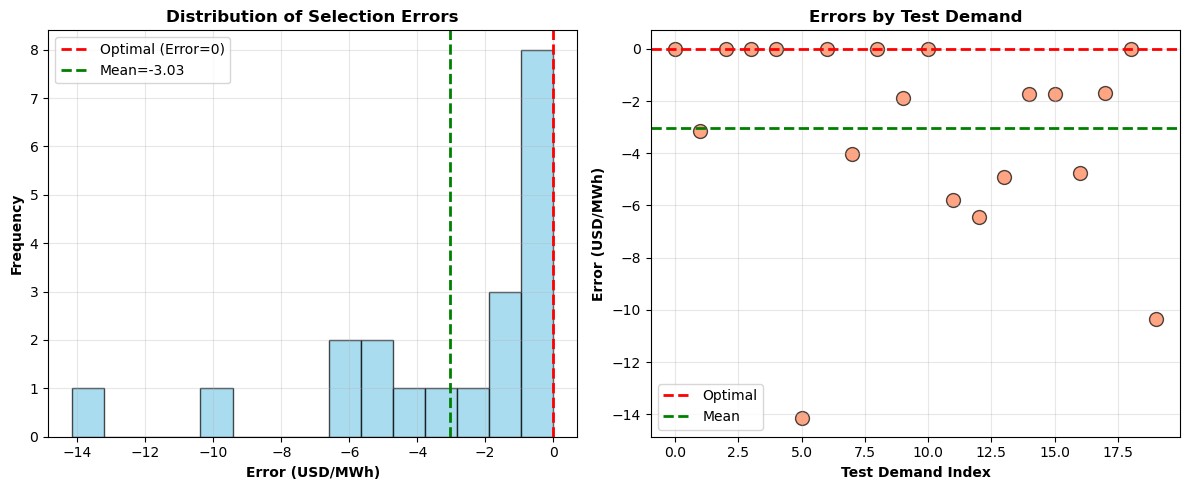


FIGURE: Feature Importance
 Saved: fig_feature_importance.png


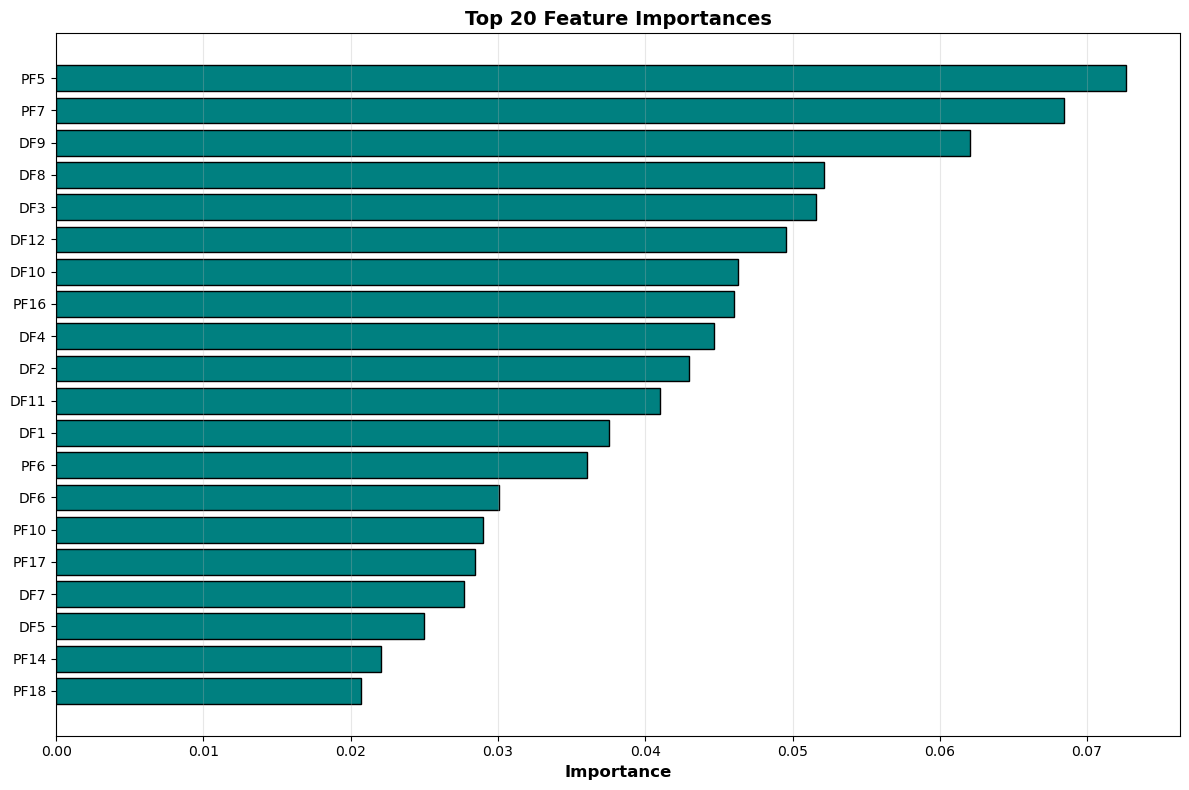

In [6]:
# 3.5 CALCULATING RMSE (EQUATION 2)
print("\n3.5 Calculating RMSE using Equation 2...")
print("RMSE = sqrt(mean(errors²))")

# Calculate RMSE
rmse_custom = np.sqrt(np.mean(errors_df['Error']**2))

print(f"\nCustom RMSE: ${rmse_custom:.2f}")

# Compare with baseline
baseline = pd.read_csv('baseline_performance.csv')
best_baseline = baseline['RMSE'].min()
avg_baseline = baseline['RMSE'].mean()

print(f"\n" + "="*80)
print("COMPARISON WITH BASELINE")
print("="*80)
print(f"Best Baseline RMSE: ${best_baseline:.2f}")
print(f"Average Baseline RMSE: ${avg_baseline:.2f}")
print(f"Our Model RMSE: ${rmse_custom:.2f}")

improvement = best_baseline - rmse_custom
improvement_pct = (improvement / best_baseline) * 100

if improvement > 0:
    print(f"\n Improvement: ${improvement:.2f} ({improvement_pct:.1f}% better)")
else:
    print(f"\n Worse by: ${-improvement:.2f} ({-improvement_pct:.1f}%)")

print("\n" + "="*80)
print("FIGURE: Error Distribution")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Histogram
axes[0].hist(errors_df['Error'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Optimal (Error=0)')
axes[0].axvline(x=errors_df['Error'].mean(), color='green', linestyle='--', 
                linewidth=2, label=f'Mean={errors_df["Error"].mean():.2f}')
axes[0].set_xlabel('Error (USD/MWh)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Distribution of Selection Errors', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Scatter plot
axes[1].scatter(range(len(errors_df)), errors_df['Error'], 
                color='coral', edgecolors='black', s=100, alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Optimal')
axes[1].axhline(y=errors_df['Error'].mean(), color='green', linestyle='--', 
                linewidth=2, label='Mean')
axes[1].set_xlabel('Test Demand Index', fontweight='bold')
axes[1].set_ylabel('Error (USD/MWh)', fontweight='bold')
axes[1].set_title('Errors by Test Demand', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig_step3_errors.png', dpi=300, bbox_inches='tight')
print(" Saved: fig_step3_errors.png")
plt.show() 
print("\n" + "="*80)
print("FIGURE: Feature Importance")
print("="*80)

# Get feature importance from the model
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='teal', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontweight='bold', fontsize=12)
plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('fig_feature_importance.png', dpi=300, bbox_inches='tight')
print(" Saved: fig_feature_importance.png")
plt.show() 

In [7]:
# SAVEING RESULTS
print("\n3.7 Saving results...")

# Save errors
errors_df.to_csv('step3_errors.csv', index=False)
print(" Saved: step3_errors.csv")

# Save feature importance
feature_importance.to_csv('step3_feature_importance.csv', index=False)
print(" Saved: step3_feature_importance.csv")

# Save summary results
results = {
    'train_r2': [train_r2],
    'test_r2': [test_r2],
    'train_rmse': [train_rmse],
    'test_rmse': [test_rmse],
    'custom_rmse': [rmse_custom],
    'mean_error': [errors_df['Error'].mean()],
    'best_baseline_rmse': [best_baseline],
    'avg_baseline_rmse': [avg_baseline]
}
results_df = pd.DataFrame(results)
results_df.to_csv('step3_results.csv', index=False)
print(" Saved: step3_results.csv")



3.7 Saving results...
 Saved: step3_errors.csv
 Saved: step3_feature_importance.csv
 Saved: step3_results.csv
